In [1]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.load import load_data
from utils.params import set_param

# Params for downsampling (specific to the dataset)
WINDOW = int(1e2)  # use 1e2
STEP = int(1e2)  # use 1e2

# Number of time steps to display when rendering graphs
SECONDS_TO_DISPLAY = 200

In [14]:
# Select the experiment to load
# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
# exp = 'p4679'
exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

# Put the shear stress (X) and time (t) into a pandas dataframe to allow
# us to work with it more easily and carry out downsampling
ts_data = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])

ts_data.head()

,X,t
0,3.28402,0.000
1,3.28402,0.001
2,3.28385,0.002
3,3.28390,0.003
4,3.28384,0.004


Sample rate: 999.9966667777742 Hz


Text(0.5, 1.0, 'Shear stress vs time')

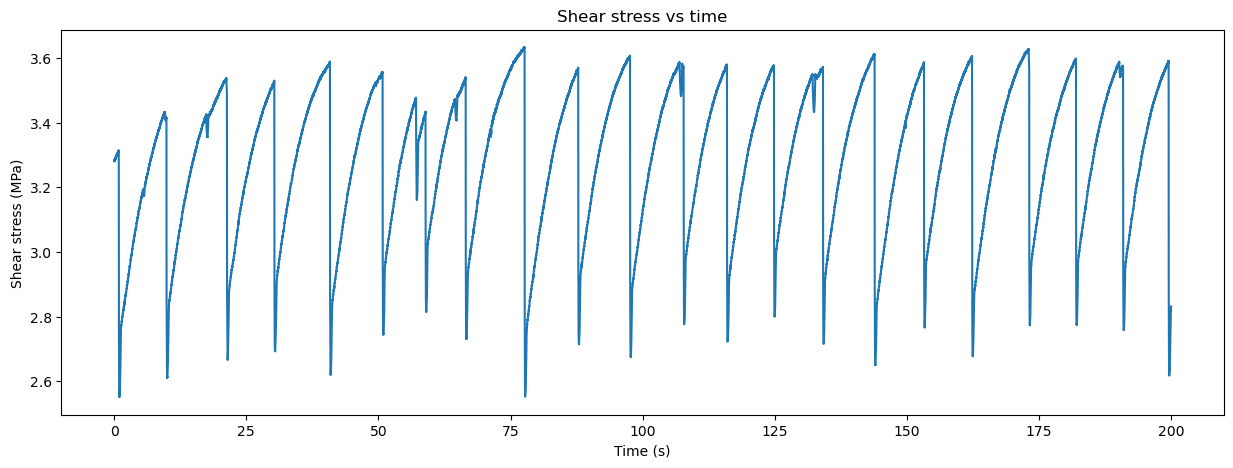

In [15]:
# Compute the sample rate from the time data
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an integer (round to nearest integer)
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Shear stress vs time")

# Not plotting derivative for now as signal is too noisy at this stage

Sample rate: 9.999966667777741 Hz


Text(0.5, 1.0, 'De-noised shear stress vs time')

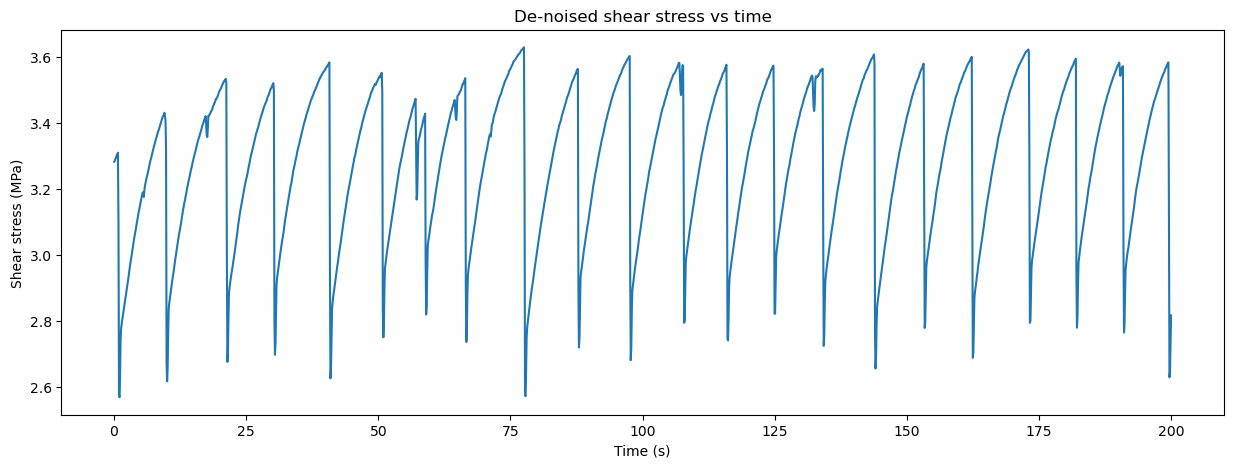

In [16]:
# Downsampling to remove noise (smoothing) and make forecasting easier (less
# points to predict)

# Apply a rolling window function with a specific window size and step size,
# then calculate the mean for each window. This is a way of downsampling the
# data, reducing its size and smoothing out short-term fluctuations.
# The dropna() function is used to remove any resulting missing values.
ts_data = ts_data.rolling(window=WINDOW, step=STEP).mean().dropna()

# Reset the index of the DataFrame. The 'drop=True' argument is used to avoid
# the old index being added as a column.
ts_data = ts_data.reset_index(drop=True)

# Compute the sample rate from the time data post downsampling
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an integer rounded to nearest integer
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised shear stress vs time")

Text(0.5, 1.0, 'Rate of change of de-noised shear stress vs time')

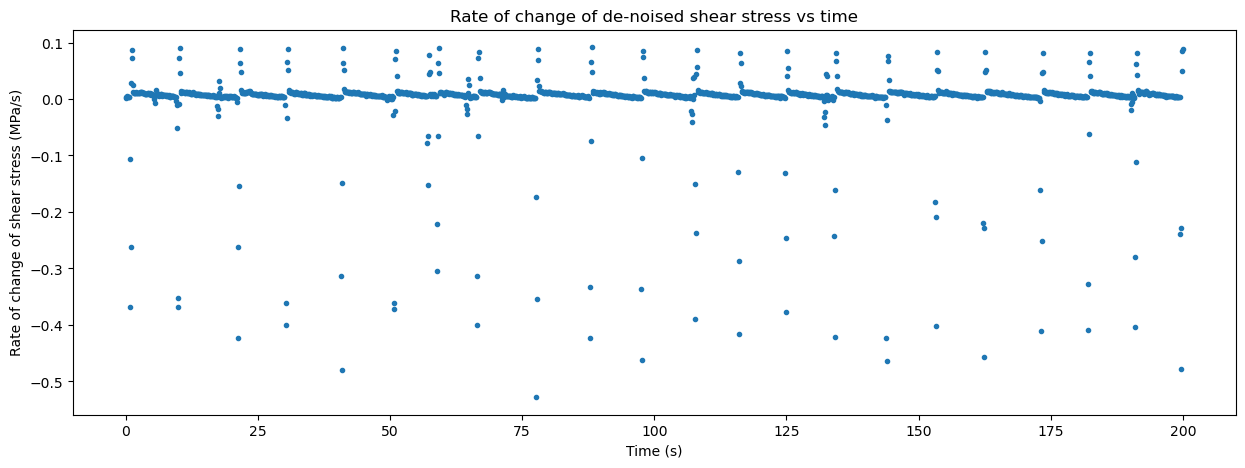

In [17]:
# Plot the derivative of the data (e.g. the rate of change of shear stress)
plt.figure(figsize=(15, 5))
plt.plot(
    ts_data["t"][:segment_in_sec],
    np.gradient(ts_data["X"][:segment_in_sec]),
    ".",
)
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title("Rate of change of de-noised shear stress vs time")

Text(0.5, 1.0, 'Log rate of change of de-noised shear stress vs time')

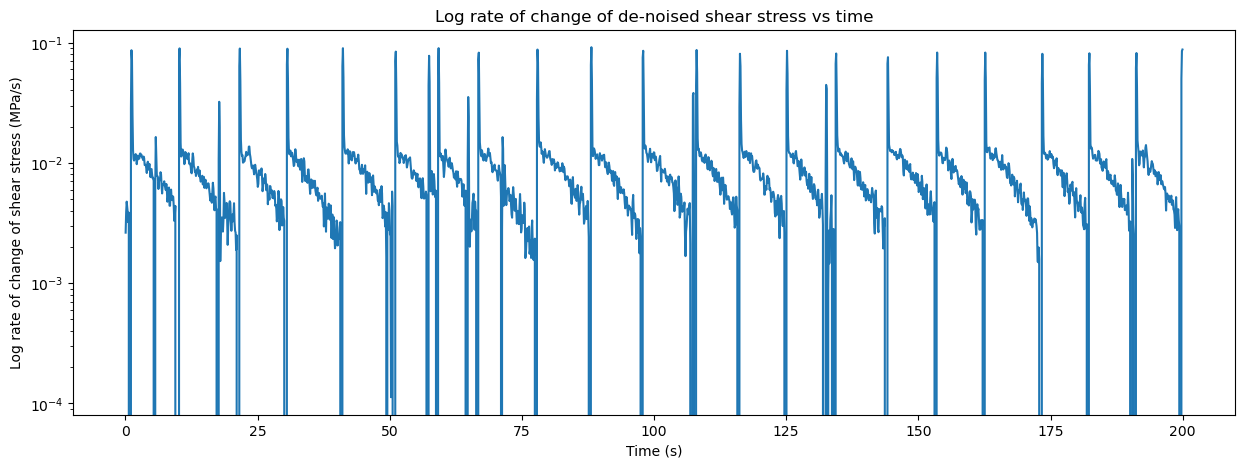

In [18]:
# Do a similar gradient plot but with a log scale (as in the above plot it is
# tricky to see the rate of change of shear stress during the stick phase)
plt.figure(figsize=(15, 5))
plt.plot(
    ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec])
)
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised shear stress vs time")

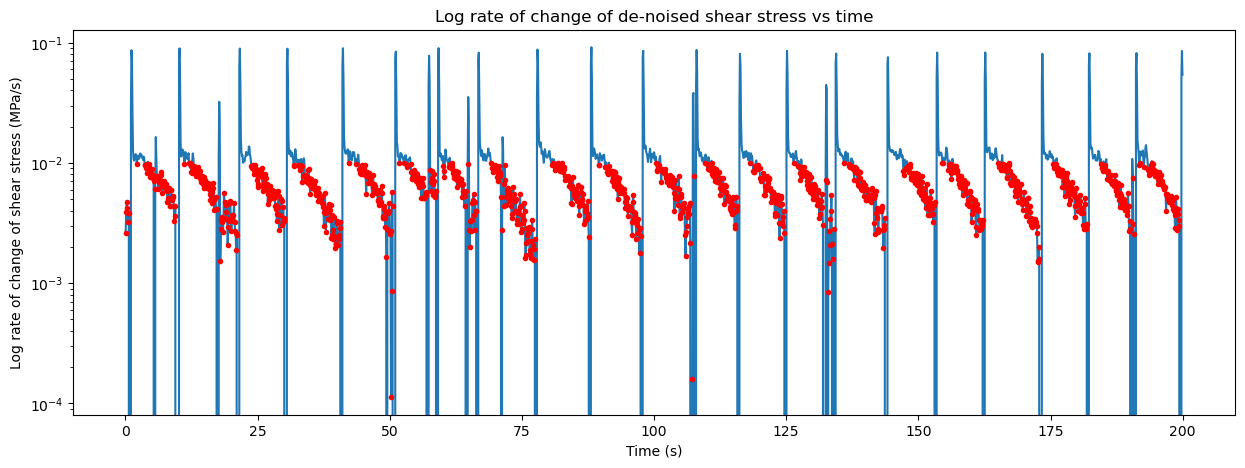

In [19]:
# Isolate and highlight the points where the rate of changes of shear stress
# gradually decreases toward 0 (i.e. the stick phase going towards the turning
# point)

# Query the indexes where the log rate of change is between 10^-2 and 10^-3

# Calculate the gradient and select indexes
gradient = np.gradient(ts_data["X"])
indexes = np.where((np.log10(np.abs(gradient))) < -2)[
    0
]

# Limit the number of data points to segment_in_sec
max_index = min(segment_in_sec, len(ts_data["t"]))
indexes = indexes[indexes < max_index]
gradient = gradient[:max_index]
time = ts_data["t"][:max_index]

# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, gradient)
plt.plot(time[indexes], gradient[indexes], "r.")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised shear stress vs time")
plt.yscale("log")
plt.show()

In [20]:
# Loop through the indexes, grouping points into buckets. This creates a bucket
# of indexes per stick phase of the signal.

# Start a new bucket if the difference between the current point and the
# previous point is greater than 1. Otherwise, add the current point to the
# current bucket.
buckets = []
for i in indexes:
    if len(buckets) == 0 or i - buckets[-1][-1] > 1:
        buckets.append([i])
    else:
        buckets[-1].append(i)

# Remove buckets with less than 10 points
buckets = [bucket for bucket in buckets if len(bucket) > 20]

# Replace negative indexes with 0
buckets = [[max(0, i) for i in bucket] for bucket in buckets]

print("Number of buckets:", len(buckets))

Number of buckets: 22


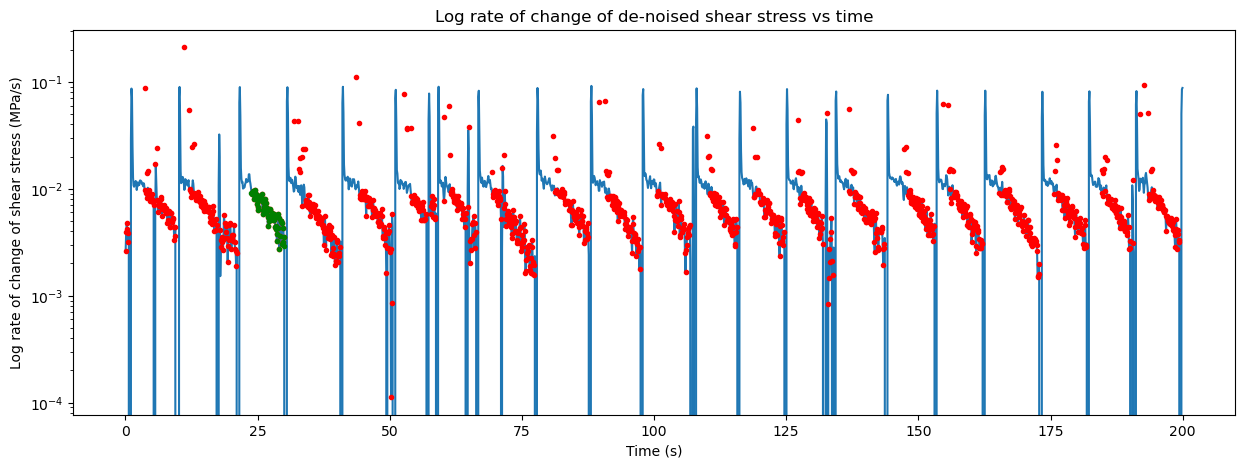

In [21]:
# Highlight the indexes in one of the buckets
bucket = buckets[3]

# Plot the indexes in one of the buckets (bucket 3)
plt.figure(figsize=(15, 5))
plt.plot(
    ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec])
)
plt.plot(ts_data["t"][indexes], np.gradient(ts_data["X"][indexes]), "r.")
# Ployt the indexes in the first bucket
plt.plot(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), "g.")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised shear stress vs time")
plt.yscale("log")

Text(0.5, 1.0, 'De-noised shear stress vs time')

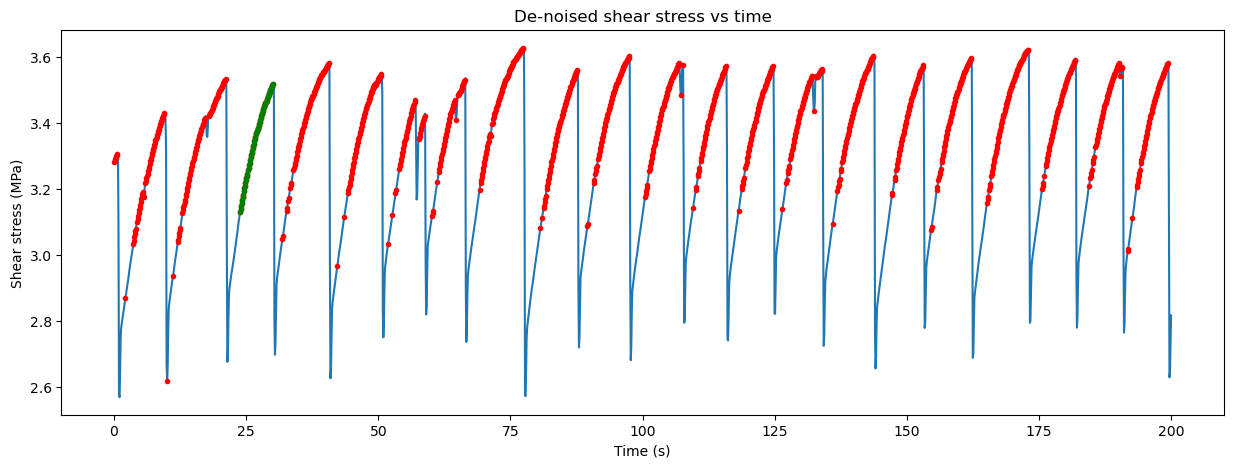

In [22]:
# Plot those identified stick phases on the original shear stress time series
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.plot(ts_data["t"][indexes], ts_data["X"][indexes], "r.")
plt.plot(ts_data["t"][bucket], ts_data["X"][bucket], "g.")
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised shear stress vs time")

Text(0.5, 1.0, 'Distribution of curve parameter 3 (constant term)')

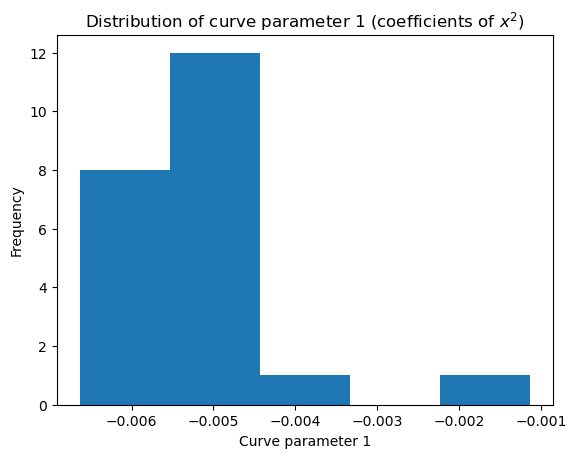

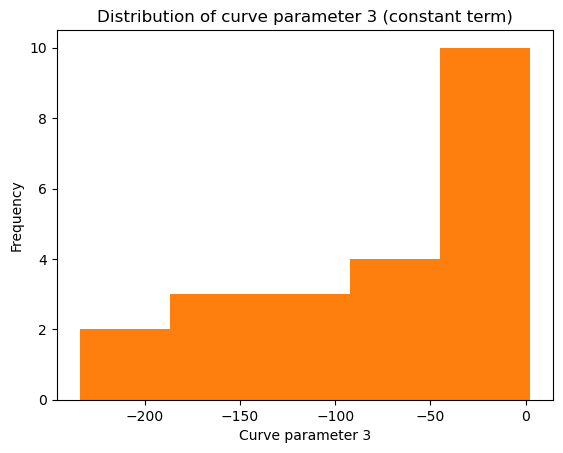

In [23]:
# Fit a curve to the data in each bucket and plot the distribution of curve 
# parameters

curve_params = []

for bucket in buckets:
    # Fit a curve (second-order polynomial) to the data in each bucket
    curve = np.polyfit(ts_data["t"][bucket], ts_data["X"][bucket], 2)
    curve_params.append(curve)

# Plot distribution of first parameter
plt.figure()
plt.hist([curve[0] for curve in curve_params], bins=5)
plt.xlabel("Curve parameter 1")
plt.ylabel("Frequency")
plt.title("Distribution of curve parameter 1 (coefficients of $x^2$)")

# Plot distribution of second parameter
plt.figure()
plt.hist([curve[1] for curve in curve_params], bins=5)
plt.xlabel("Curve parameter 2")
plt.ylabel("Frequency")
plt.title("Distribution of curve parameter 2 (coefficients of $x$)")

# Plot distribution of third parameter
# plt.figure(figsize=(15, 5))
plt.hist([curve[2] for curve in curve_params], bins=5)
plt.xlabel("Curve parameter 3")
plt.ylabel("Frequency")
plt.title("Distribution of curve parameter 3 (constant term)")

Text(0.5, 1.0, 'Rate of change of de-noised shear stress vs time')

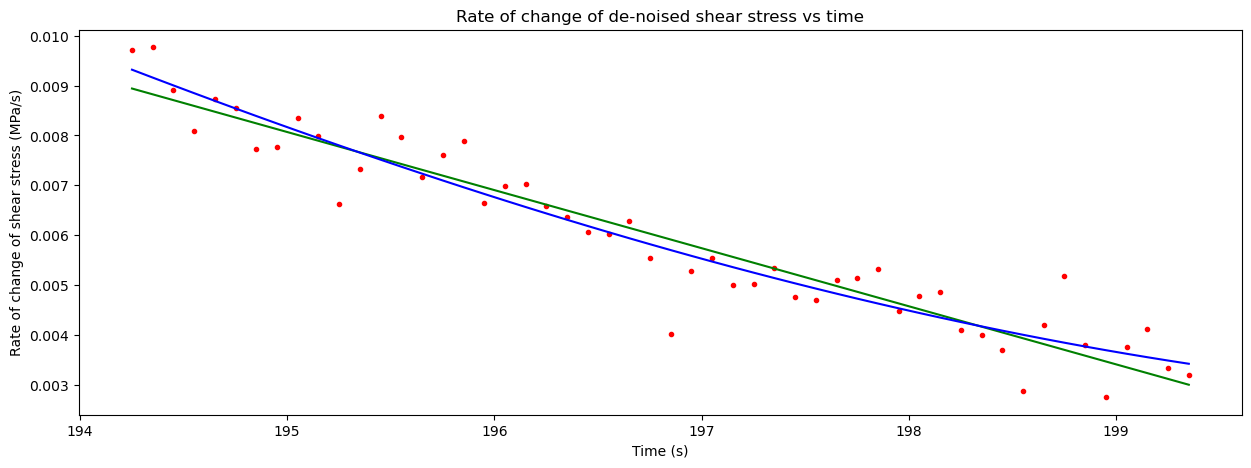

In [24]:
# Fit a line to the data in the first bucket
f = np.poly1d(
    np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 1)
)

# Fit a curve to the data in the first bucket
p = np.poly1d(
    np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 3)
)

# Plot the indexes in the first bucket
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), "r.")
# Plot the line of best fit
plt.plot(ts_data["t"][bucket], f(ts_data["t"][bucket]), "g")
# Plot the curve of best fit
plt.plot(ts_data["t"][bucket], p(ts_data["t"][bucket]), "b")
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title("Rate of change of de-noised shear stress vs time")

Closest x-intercept: 201.93230035802688
Number of steps to x-intercept: 177.93230035802688
Number of x-steps to x-intercept: 177.93230035802688
Closest x-intercept: 201.93230035802688
Number of steps to x-intercept: 0       201.881800
1       201.781800
2       201.681800
3       201.581799
4       201.481799
           ...    
2995     97.619198
2996     97.719198
2997     97.819199
2998     97.919199
2999     98.019199
Name: t, Length: 3000, dtype: float64


Text(0.5, 1.0, 'TTsF vs time')

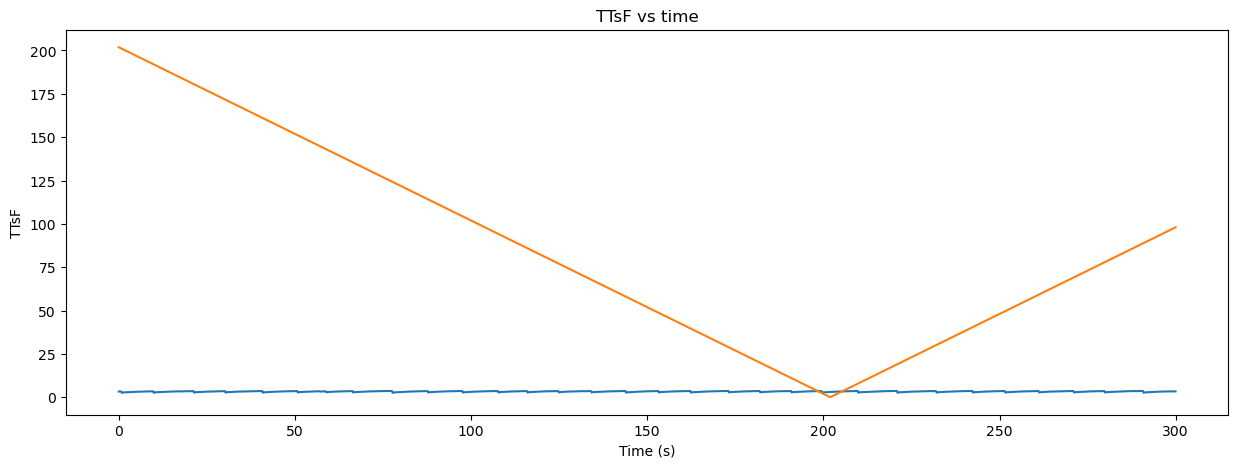

In [25]:
def interval_to_x_intercept(f, x1):
    """
    Determine the number of steps to the x-intercept of a polynomial function
    
    Args:
    f, given a starting point x1.

    Returns:
    steps, the number of steps in the x-direction to the x-intercept.
    """
    # y = ax^3 + bx^2 + cx + d

    # Get x-intercept (roots of the polynomial)
    x_intercept = f.roots

    # Filter real roots
    real_roots = [root.real for root in x_intercept if np.isreal(root)]

    # Find closest x-intercept
    closest_x_intercept = min(real_roots, key=lambda x: abs(x - x1))

    print("Closest x-intercept:", closest_x_intercept)

    # Compute number of steps
    steps = abs(x1 - closest_x_intercept)
    print("Number of steps to x-intercept:", steps)
    return steps


steps_to_x_intercept = interval_to_x_intercept(f, 24)
print("Number of x-steps to x-intercept:", steps_to_x_intercept)

# Predict the TTsF by passing the predict TTsF for the stick slip cycle in 
# `bucket`
ts_data["TTsF"] = interval_to_x_intercept(f, ts_data["t"])


# Plot the TTsF
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"], ts_data["X"])
plt.plot(ts_data["t"], ts_data["TTsF"])
plt.xlabel("Time (s)")
plt.ylabel("TTsF")
plt.title("TTsF vs time")

Text(0.5, 1.0, 'Fitted curves of rate of change of shear stress across all stick cycles')

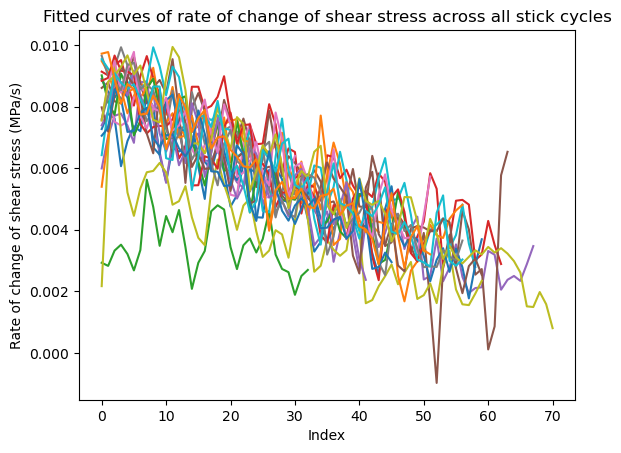

In [26]:
# Plotting the rate of change of shear stress for all stick (loading) cycles in 
# the time series

# Create a collection of stick signals
stick_signals = [ts_data["X"][bucket] for bucket in buckets]
derivatives = []

for stick_signal in stick_signals:
    derivatives.append(np.gradient(stick_signal))
    plt.plot(derivatives[-1])
plt.xlabel("Index")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title(
    "Fitted curves of rate of change of shear stress across all stick cycles"
)